<H1>Challenge: Make Your Own Regression Model</H1><br><br>
This project uses the New York State crime statistics data for 2013, taken from <a href='https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'>the FBI UCR repository</a>.<br><br>

After hours of tinkering with features, I was able to come up with a model that predicts property crime per capita to within .2% with a nice residual distribution. For brevity, I've cut all the tinkering out of this notebook and I'll just explain the features I ended up using.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
#df[['cbrt_EPCpc', 'Murd', 'Violent crime_per_capita']] WORKS GREAT!

In [2]:
df = pd.read_excel('clean_crime_data.xlsx')

Before engineering most features, I transform them to per capita crime rates.
<br><br>
First, following some handy advice from the <a href'https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/'> stats with cats blog</a>, I apply a cube root transform to the target variable (Property crime per capita) to make it look more normal.

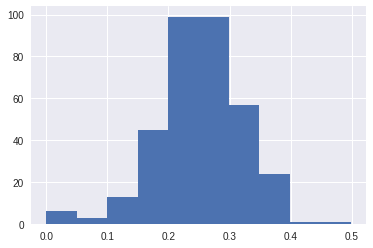

In [3]:
df['Property crime_per_capita'] = df['Property crime']/df.Population
df['cbrt_PC'] = np.cbrt(df['Property crime_per_capita'])
plt.hist(df['cbrt_PC']);

That looks kind of normal! Now I'll build my first input feature, called 'Murd', which is a binary feature describing if any murders were reported.

In [4]:
df['Murd'] = np.where((df['Murder and nonnegligent manslaughter'] > 0), 1, 0)

The next feature takes advantage of the fact that "property crimes" are the sum of a number of other types of crimes. I add all of those types of crimes together. One problem is that the data set includes inconsistent data on arson; many cities have null fields for this category, but the metadata indicates this does not mean they have zero arson. I found a strong linear correlation between burglary and arson, so I built a quick-and-dirty linear regression to fill in the gaps in our arson data, and then add all of the relevant property crimes together, finally dividing by population, for a per-capita property crime estimate. Of course, I need to take the cube root to match the transform I did on the outcome variable

In [5]:
df['known_arson'] = np.where((df['Arson3'].notnull()), df['Arson3'], 0)
df['has_arson'] = np.where((df['Arson3'] > 0), 1, 0)
ars = df[df['has_arson'] == 1]
ars_regr = linear_model.LinearRegression()
burgs = ars.Burglary.values.reshape(-1, 1)
arsn = ars.known_arson.values.reshape(-1, 1)
ars_regr.fit(burgs, arsn)
ars_regr.score(burgs, arsn)
df['pred_arson'] = ars_regr.predict(df['Burglary'].values.reshape(-1, 1))
df['pred_arson'] = np.where((df['pred_arson'] < 0), 0, 1)
df['est_arson'] = np.where((df['has_arson'] == 1), df['Arson3'], df['pred_arson'])
df['est_arson_per_capita'] = df['est_arson']/df.Population
df['est_PC_per_capita'] = (df['Burglary'] + df['Larceny-theft'] + df['Robbery'] + df['Motor vehicle theft'] + df['est_arson'])/df.Population
df['cbrt_EPCpc'] = np.cbrt(df['est_PC_per_capita'])

The last helpful feature is simply violent crime per capita. This takes into account all of the non-property crimes. This feature helps the most without any transformations.

In [6]:
df['Violent crime_per_capita'] = df['Violent crime']/df.Population

In [7]:
#What the heck. Let's make a model.
from sklearn import linear_model
regr = linear_model.LinearRegression()
train = df[['cbrt_EPCpc', 'Violent crime_per_capita', 'Murd']]
target = df['cbrt_PC']
regr.fit(train, target);
print('\nR-squared:')
print(regr.score(train, target))
predictions = regr.predict(df[['cbrt_EPCpc', 'Violent crime_per_capita', 'Murd']])
pred = np.power(predictions, 3)
targ = df['Property crime_per_capita']


R-squared:
0.999525024058


In [8]:
predictions = regr.predict(df[['cbrt_EPCpc', 'Violent crime_per_capita', 'Murd']])
pred = np.power(predictions, 3) #transform predictions back to regular property crimes per capita
targ = df['Property crime_per_capita']

In [9]:
residual = targ - pred

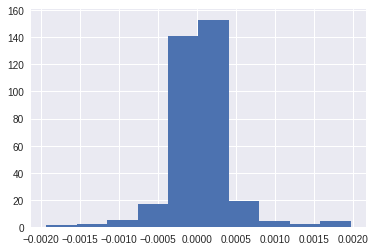

In [10]:
plt.hist(residual); #Residual looks pretty normal!

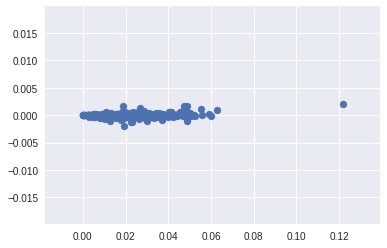

In [11]:
plt.scatter(x=pred, y=residual); #Looks kinda homoscedastic! :)